# Countermeasures model v1

Changes:
* Fixed convolution by creating a tested library version
* Cleared up import code, removed obsolete mask, added text cells
* Improve plotting & writeouts
* Renamed from "basic" to v1 (this is hardly a simple model)
* Move most code to library (WIP)

Model v2:
* Add country unreliability parameter, used as scale multiplier in growth rate and measurement noise.

## Import & initialization

In [1]:
### Initial imports

import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect

## Loading data and parameter settings

In [2]:
Regions = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
Features = ['Gatherings limited to', 'Business suspended',
       'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Minor distancing and hygiene measures',
       'Phone line', 'Mask wearing', 'Asymptomatic contact isolation']
data = cm_effect.loader.Loader('2020-02-15', '2020-04-05', Regions, Features)

# Probability of being in Confirmed cases X days after transmission, from 0
# Generated from Poisson dist., must sum to 1.0
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
print(f"Delayprob sum={DelayProb.sum()}, E[DP]={np.sum(DelayProb*np.arange(len(DelayProb)))}")


[2020-04-09 17:00:01,153] INFO(epimodel.regions): Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
[2020-04-09 17:00:01,311] INFO(numexpr.utils): NumExpr defaulting to 4 threads.


Delayprob sum=1.0, E[DP]=6.78


## Model definition

In [7]:
with cm_effect.models.CMModelV2(data) as model:
    model.build_reduction_lognorm()
    model.build_rates()

## Run MCMC inference

1000 steps is enough for seeing the convergence and rough results, more is better, though.

In [4]:
model.run(1000)

[2020-04-09 17:00:06,247] INFO(pymc3): Auto-assigning NUTS sampler...
[2020-04-09 17:00:06,247] INFO(pymc3): Initializing NUTS using adapt_diag...


CMReduction_log__         12.45
BaseGrowthRate_log__      -1.75
RegionGrowthRate_log__     7.98
RegionScaleMult_log__    -49.05
Name: Log-probability of test_point, dtype: float64


[2020-04-09 17:00:07,982] INFO(pymc3): Multiprocess sampling (2 chains in 2 jobs)
[2020-04-09 17:00:07,983] INFO(pymc3): NUTS: [RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:23<00:00, 125.90draws/s]
[2020-04-09 17:00:32,745] ERROR(pymc3): The estimated number of effective samples is smaller than 200 for some parameters.


## Plot chain stability

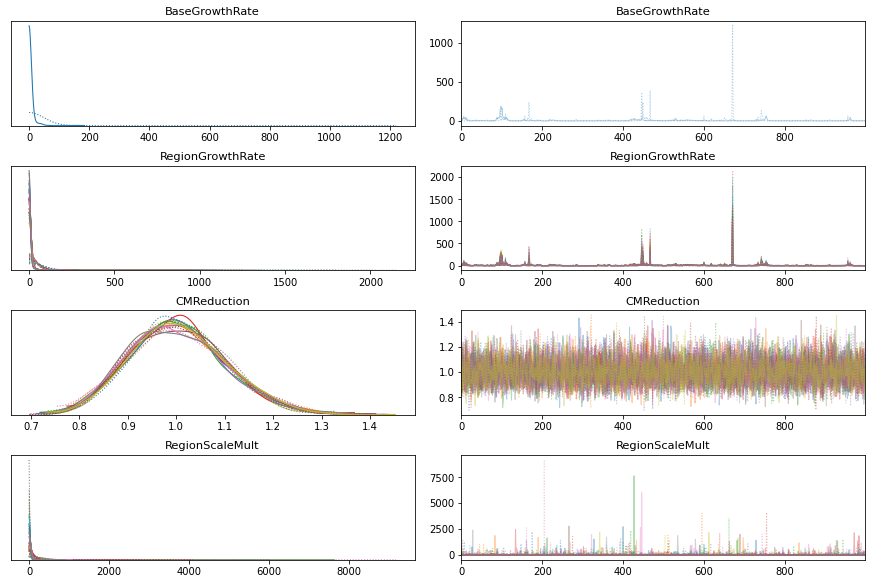

In [5]:
_ = model.plot_traces()

## Plot inferred countermeasure effect

Effects are multiplicative (e.g. for a countermeasure that is a strenghtening of another, the inferred strenght is the additional multiplier).

The countermeasure strength is the multiplicative effect at feature=1.0.

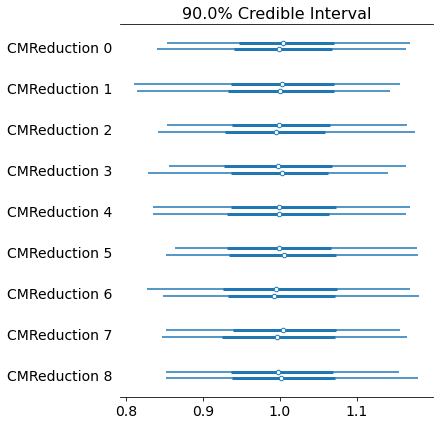

In [6]:
_ = model.plot_effect()

In [ ]:
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction {statstr(trace['CMReduction'][:,i])}")

In [ ]:
import plotly
from plotly import graph_objects as go
import plotly.express as px
import datetime

def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
fig = go.FigureWidget()
for i, c in enumerate(Cs):
    d = trace['DailyGrowth'][:,i,:]
    color = (px.colors.qualitative.Dark24 * 10)[i]
    plot_line_CIs(fig, Ds[CMDelayCut:], d, c, color)
datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plotly.io.write_html(fig, f'{datestr}_growth_estimated_v2.html', include_plotlyjs='cdn')
fig